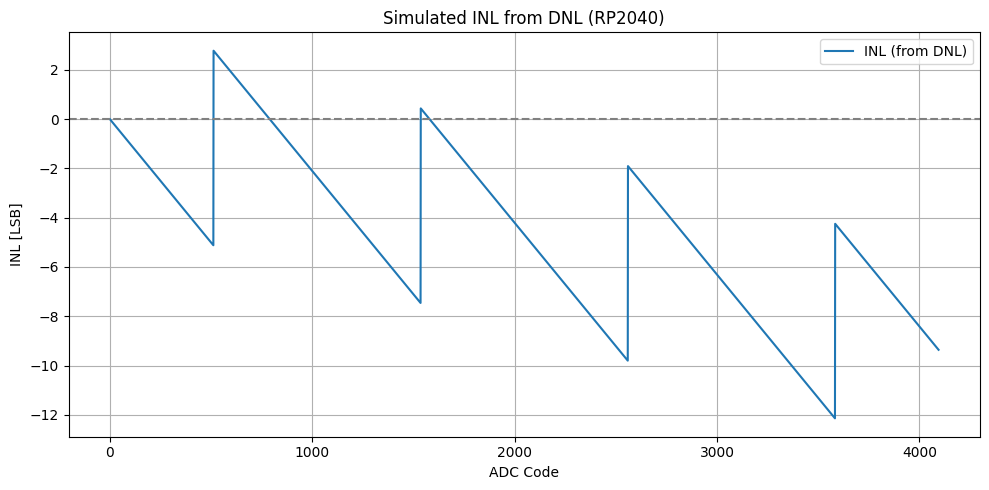

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# ADC 分解能（12bit）
adc_max = 4096

# 初期化：DNL配列（全体を1.0 LSBと仮定）
dnl = np.ones(adc_max)

# 特定ポイントでスパイク（+8.9 LSB）
spike_indices = [512, 1536, 2560, 3584]
for idx in spike_indices:
    dnl[idx] = 8.9

# INLはDNLの累積和（中央値基準に補正も可）
inl = np.cumsum(dnl - 1.01)  # -1.0は理想DNLとの差

# グラフ表示
plt.figure(figsize=(10, 5))
plt.plot(inl, label='INL (from DNL)')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Simulated INL from DNL (RP2040)")
plt.xlabel("ADC Code")
plt.ylabel("INL [LSB]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


0.6539792387543253
3.2698961937716264
1.529100529100529


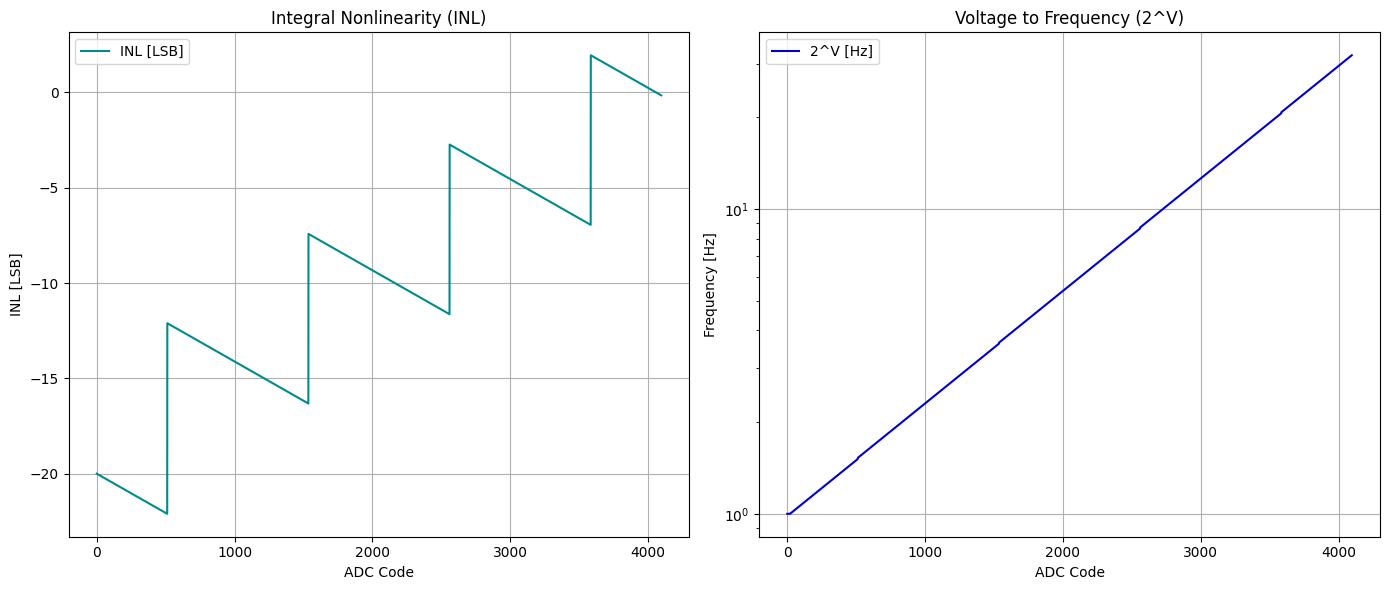

✅ CSVファイルに出力しました: ./adc_correction_data.csv


In [87]:
import matplotlib.pyplot as plt
import csv

def export_to_csv(_INL, _adc2powV, filename="./adc_correction_data.csv"):
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["ADC Code", "INL (LSB)", "Frequency (Hz)"])
        for i in range(4096):
            writer.writerow([i, _INL[i], _adc2powV[i]])
    print(f"✅ CSVファイルに出力しました: {filename}")

def plot_graphs(_INL, _adc2powV):
    x = list(range(4096))

    plt.figure(figsize=(14, 6))

    # INL グラフ
    plt.subplot(1, 2, 1)
    plt.plot(x, _INL, label='INL [LSB]', color='darkcyan')
    plt.title("Integral Nonlinearity (INL)")
    plt.xlabel("ADC Code")
    plt.ylabel("INL [LSB]")
    plt.grid(True)
    plt.legend()

    # pow(2, V/OCT) グラフ
    plt.subplot(1, 2, 2)
    plt.plot(x, _adc2powV, label='2^V [Hz]', color='mediumblue')
    plt.title("Voltage to Frequency (2^V)")
    plt.xlabel("ADC Code")
    plt.ylabel("Frequency [Hz]")
    plt.yscale("log")  # 対数スケールの方が音階的に自然
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


_INL = [0 for i in range(4096)]
_adc2powV = [0 for i in range(4096)]

input_max = 5.0
resister_voltage_splitter = 189000.0 / (100000.0 + 189000.0)
adc_input_max = resister_voltage_splitter * input_max
scale = input_max / adc_input_max

print(resister_voltage_splitter)
print(adc_input_max)
print(scale)

def generateINL(noiseFloor = 0.0):
    spike_peak = [10, 8.9, 8.9, 8.9]
    spikes_adc = [512, 1536, 2560, 3584]

    for i in range(4096):
        if (noiseFloor > 0.0):
            _INL[i] = (-0.009 * i) - (noiseFloor - (noiseFloor * (i / 4095.0)))
        else:
            _INL[i] = (-0.01 * i)

    for i in range (4):
        spike_pos = spikes_adc[i]
        for j in range(spike_pos, 4096):
            _INL[j] += spike_peak[i]

def constrain(val, min, max):
    if (val < 0):
        return min
    if (val > max):
        return max
    return val

def generate(vref = 3.3):
    lsb_voltage = vref / 4095.0

    for adc in range(4096):
        corrected_adc = adc + _INL[adc]
        corrected_adc = constrain(corrected_adc, 0.0, 4095.0)
        voltage = corrected_adc * lsb_voltage
        voct = voltage * scale
        _adc2powV[adc] = pow(2, voct)

4095 - 3584

generateINL(20)
generate(3.269)
plot_graphs(_INL, _adc2powV)
export_to_csv(_INL, _adc2powV)